In [3]:
import json
import string
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_recall_fscore_support
import time
from datetime import datetime
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [25]:
covid_data = [json.loads(event) for event in open('project-data/covid.data.jsonl', "r").readlines()]
# covid_data = covid_data[:64]

In [26]:
# {hashtag_event}
# hashtag_event = {hashtag, frequencies}

hashtags = []                          
for event in covid_data:
    event_hashtags = []
    for tw in event:
        twitter_hashtags = tw['entities']['hashtags']
        for hashtag in twitter_hashtags:
            event_hashtags.append(hashtag['text'])
    hashtags.append(Counter(event_hashtags))
    
hashtags[0]

Counter({'Tenet': 1})

In [27]:
users_info = []

for event in covid_data:
    event_users_info = []
    for tw in event:
        tw_user = tw['user']
        tw_user_info = {"followers_count": tw_user["followers_count"],      # The number of followers this account currently has. 
                       "friends_count": tw_user["friends_count"],           # The number of users this account is following (AKA their “followings”)
                       "listed_count": tw_user["listed_count"],             # The number of public lists that this user is a member of
                       "statuses_count": tw_user["statuses_count"],         # The number of Tweets (including retweets) issued by the user
                       "favourites_count": tw_user["favourites_count"],     # The number of Tweets this user has liked in the account’s lifetime.
                       "verified": tw_user["verified"]                      # When true, indicates that the user has a verified account.
                       }
        event_users_info.append(tw_user_info)
    users_info.append(event_users_info)
    
users_info[0]

[{'followers_count': 26179,
  'friends_count': 18,
  'listed_count': 112,
  'statuses_count': 2512,
  'favourites_count': 537,
  'verified': False}]

In [28]:
len(covid_data)

17458

In [29]:
rum_users_info = []
nonrum_users_info = []

for i in range(len(bert_preds)):
    if bert_preds[i] == 1:
        rum_users_info.append(users_info[i])
    elif bert_preds[i] == 0:
        nonrum_users_info.append(users_info[i])

In [9]:
bert_preds = torch.load("preds.pt")

In [31]:
rum_sources_info = [event[0] for event in rum_users_info]
# rum_replies_info = [event[1:] for event in rum_users_info]

nonrum_sources_info = [event[0] for event in nonrum_users_info]
# nonrum_replies_info = [event[1:] for event in nonrum_users_info]

In [55]:
rum_sources_info[0]

{'followers_count': 1986767,
 'friends_count': 96,
 'listed_count': 8114,
 'statuses_count': 14406,
 'favourites_count': 665,
 'verified': True}

In [56]:
sources_follow_counts = [s["followers_count"] for s in rum_sources_info]
sources_friend_counts = [s["friends_count"] for s in rum_sources_info]
sources_list_counts = [s["listed_count"] for s in rum_sources_info]
sources_statuse_counts = [s["statuses_count"] for s in rum_sources_info]
sources_favourite_counts = [s["favourites_count"] for s in rum_sources_info]
sources_verified = [s["verified"] for s in rum_sources_info]

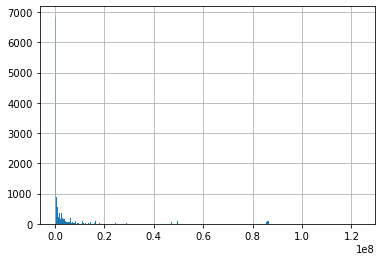

In [64]:
pd.Series(sources_follow_counts).hist(bins=500)

In [53]:
def print_stats(name, nums):
    print(name)
    print("means: ", np.mean(nums))
    print("means: ", np.median(nums))
    print("variance: ", np.std(nums))
    print()
    
print_stats("follow_counts", sources_follow_counts)
print_stats("friend_counts", sources_friend_counts)
print_stats("list_counts", sources_list_counts)
print_stats("statuses_counts", sources_statuse_counts)
print_stats("favourites_counts", sources_favourite_counts)
print_stats("verified", sources_verified)

follow_counts
means:  4136863.111198738
means:  408805.0
variance:  11396283.53388727

friend_counts
means:  6965.899842271293
means:  1040.0
variance:  22874.385015130138

list_counts
means:  14546.0
means:  2162.0
variance:  34390.07291911

statuses_counts
means:  144600.02602523658
means:  62813.0
variance:  184417.96725608394

favourites_counts
means:  24090.609621451105
means:  2829.5
variance:  70707.39007132531

verified
means:  0.7602523659305994
means:  1.0
variance:  0.426929392320938



follow_counts
means:  5447267.924397777
means:  387772.0
variance:  15163737.448621502

friend_counts
means:  7935.383323038913
means:  1106.0
variance:  30086.093635487217

list_counts
means:  15522.178937615812
means:  2202.0
variance:  35024.57398193761

statuses_counts
means:  113796.57930821495
means:  39039.5
variance:  168994.72483384045

favourites_counts
means:  24288.141630636193
means:  3164.5
variance:  62197.14864137262

verified
means:  0.7421865348980853
means:  1.0
variance:  0.43743077431069993



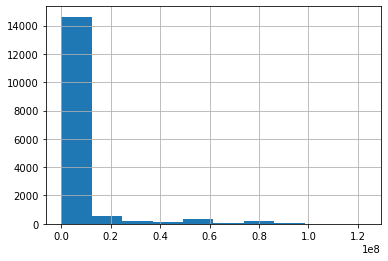

In [60]:
sources_follow_counts = [s["followers_count"] for s in nonrum_sources_info]
sources_friend_counts = [s["friends_count"] for s in nonrum_sources_info]
sources_list_counts = [s["listed_count"] for s in nonrum_sources_info]
sources_statuse_counts = [s["statuses_count"] for s in nonrum_sources_info]
sources_favourite_counts = [s["favourites_count"] for s in nonrum_sources_info]
sources_verified = [s["verified"] for s in nonrum_sources_info]


print_stats("follow_counts", sources_follow_counts)
print_stats("friend_counts", sources_friend_counts)
print_stats("list_counts", sources_list_counts)
print_stats("statuses_counts", sources_statuse_counts)
print_stats("favourites_counts", sources_favourite_counts)
print_stats("verified", sources_verified)

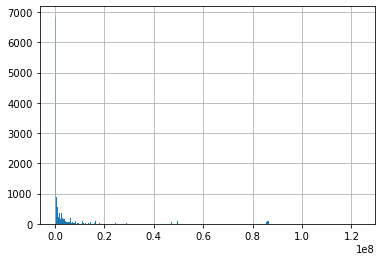

In [63]:
pd.Series(sources_follow_counts).hist(bins=500)

In [ ]:
class RumourClassifier3(nn.Module):
    def __init__(self):
        super(RumourClassifier3, self).__init__()
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        self.cls_layer = nn.Linear(768, 1)
        self.dropout = nn.Dropout(0.9)

    def forward(self, seq, attn_masks, token_type_ids):
        '''
        Inputs:
          -seq: Tensor of shape [B, T] containing token ids of sequences
          -attn_masks: Tensor of shape [B, T] containing attention masks to be used
        '''
        # feed the input to bert model to obtain contextualized representation
        outputs = self.bert_layer(seq, attention_mask=attn_masks, token_type_ids=token_type_ids)
        cont_reps = outputs.last_hidden_state

        # obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        # pooled_output = self.dropout(cls_rep)

        # feeding cls_rep into the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits

In [ ]:
bert_net = RumourClassifier3()
bert_net.load_state_dict(torch.load("preds/adamw_50_date.dat"))

In [ ]:
def predict(net, dataloader, gpu):
    net.eval()
    preds = []
    mean_acc, mean_loss, mean_precision, mean_recall = 0, 0, 0, 0
    count = 0
    tn, fp, fn, tp = 0, 0, 0, 0
    with torch.no_grad():
        for seq, attn_masks, token_type_ids, labels in dataloader:
            bs = labels.shape[0]
            seq, attn_masks, token_type_ids, labels = seq.cuda(gpu), attn_masks.cuda(gpu), token_type_ids.cuda(gpu), labels.cuda(gpu)
            logits = net(seq, attn_masks, token_type_ids)
            preds.append(logits)
    return preds

In [ ]:
def to_date(date_str):
    return datetime.strftime(datetime.strptime(date_str,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S')

covid_data_sort = [sorted(event, key=lambda x : to_date(x["created_at"])) for event in covid_data]

In [ ]:
# remove url
def remove_urls(vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

def remove_ats(vTEXT):
    vTEXT = re.sub(r'@[^\s]* ', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

def extract_info(data, info="text"):
    res = []
    for i in range(len(data)):
        event = data[i]
        event_info = []
        for tw in event:
#             event_info.append(remove_ats(tw[info]))
            event_info.append(remove_ats(remove_urls(tw[info])))
        res.append(event_info)
    return res

covid_sents = extract_info(covid_data_sort)     # {event}  where event={source,apply1,apply2,...}

In [ ]:
def combine_replies(replies):
    res = ""
    for r in replies:
        res += r
    return res

covid_all = [[event[0], combine_replies(event[1:])] for event in covid_sents]

In [ ]:
# define the dataset class
class TwitrerDataset(Dataset):
    def __init__(self, X, source_maxlen, reply_maxlen):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.source_maxlen = source_maxlen
        self.reply_maxlen = reply_maxlen
        self.X = X
        print("init done")
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        # selecting the sentence at the specific index
        print("1----------")
        source, replies = self.X[index]

        # preprocessing the text to be suitable for BERT
        s_tokens = self.tokenizer.tokenize(source)
        s_tokens = ['[CLS]'] + s_tokens + ['[SEP']       # insert CLS and SEP token
        if len(s_tokens) < self.source_maxlen:                # keep the same length of each sentence
            s_tokens = s_tokens + ['[PAD]' for _ in range(self.source_maxlen-len(s_tokens))]
        else:
            s_tokens = s_tokens[:self.source_maxlen-1] + ['SEP']

        print("2----------")
        r_tokens = self.tokenizer.tokenize(replies)
        r_tokens = r_tokens + ['[SEP']
        if len(r_tokens) < self.reply_maxlen:                # keep the same length of each sentence
            r_tokens = r_tokens + ['[PAD]' for _ in range(self.reply_maxlen-len(r_tokens))]
        else:
            r_tokens = r_tokens[:self.reply_maxlen-1] + ['SEP']

        print("3---------")
        tokens_ids = self.tokenizer.convert_tokens_to_ids(s_tokens) + self.tokenizer.convert_tokens_to_ids(r_tokens) # obtaining the indices of tokens in vocab
        tokens_ids_tensor = torch.tensor(tokens_ids)   

        attn_mask = (tokens_ids_tensor != 0).long()        # attention mask (identity where is padded)

        token_type_ids = torch.tensor([0 for _ in range(source_maxlen)]+[1 for _ in range(reply_maxlen)])

        return tokens_ids_tensor, attn_mask, token_type_ids        return tokens_ids_tensor, attn_mask, token_type_ids

In [ ]:
# hyperparameters
batch_size = 2
num_worders = 2
lr = 2e-5
source_maxlen, reply_maxlen = 30, 30

# creating instances of training and dev set
covid_set = TwitrerDataset(covid_all, source_maxlen=source_maxlen, reply_maxlen=reply_maxlen)

In [ ]:
covid_set

In [ ]:
# creating dataset loader
covid_loader = DataLoader(covid_set, batch_size=batch_size, num_workers=num_worders)

print("Done preprocessing training and development data.")

In [ ]:
next(covid_loader)

In [ ]:
for e in covid_loader:
    print(e)
    break

In [ ]:
for it, e in enumerate(covid_loader):
    print(it)
    print(e)

In [2]:
# !pip install spacytextblob, spacy
# !python -m spacy download en_core_web_sm

In [9]:
# polarity: float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.
# subjective: personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [11]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
text = 'it is  a good thing '
doc = nlp(text)
print(doc._.polarity)      # Polarity: -0.125
print(doc._.subjectivity)  # Sujectivity: 0.9
print(doc._.assessments)   # Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]

0.7
0.6000000000000001
[(['good'], 0.7, 0.6000000000000001, None)]
